# Producing rainfall profiles for Lin Dyke
Synthetic summary profiles have been produced for extreme UK rain storms, which describe the intensity of rainfall over time.  
This work tests the extent to which use of these different profiles affects the flooding outcomes.  
The profiles are tested using a 2D Hec-Ras model of the Lin Dyke catchments in east Leeds.  

A 6 hour duration, 100 year return period event is initially focussed on (with the idea that if differences between profiles are identified at this return period then further investigation will be made of whether differences are also present for less rare events). The total rainfall volume associated with a 6hr, 1-in-100 year event in the Lin Dyke catchment  is extracted from ReFH2 (and is 59.98mm).

The Hec-Ras model requires a rainfall input which describes the rainfall depth at each minute during the rain storm event duration. The summary profiles describe the proportion of the total rainfall volume which falls in each of 12 time steps in any event duration. To use these to generate a rainfall input in the required format for a particular cluster:
* Extract the information for just that cluster, for the correct duration bins 
* For each of the 12 time steps, multiply the proportion of rain found in this timestep by the total event rainfall (59.98mm) to get the total rainfall depth which should fall in this time step
* In the case of a 6hr duration event, each of the 12 timesteps is 30 minutes long. The total rainfall depth falling in that 30 minute period is assumed to fall at a constant rate during that 30 minute interval. And so each minute within the interval is assigned a rainfall depth of 1/30th of the time step total
* The cumulative rainfall depth at each minute, and rainfall rate in each minute is also calculated

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import math
from matplotlib import dates as mdates
import matplotlib.patches as mpatches
import sys
sys.path.insert(1, '../')

from Functions import *

# Read in data needed to produce synthetic summary profiles
### Define total event rainfall for 6h duration, 100 year return period event in Lin Dyke

In [16]:
total_event_rainfall = 59.29
total_duration_minutes = (60* 6) +1
duration = '6h'

### Read in synthetic summary profiles

In [17]:
# Read in profiles
profiles = pd.read_csv("kmeans_15clustersPerDur.csv")
# Just keep prain (proportion of rainfall in each timestep)
profiles = profiles[profiles['Variable'] == 'prain']

In [25]:
colors = ["darkblue","indianred","paleturquoise","darkred","darkred","grey","darkred","darkblue","grey","paleturquoise","paleturquoise","indianred","grey","indianred","darkblue"]
# colors = ['darkblue']*3 + ['paleturquoise']*3 + ['grey']*3+ ['indianred']*3+['darkred']*3

# Produce synthetic profiles for Lin Dyke Catchment
## Calculate the rainfall depth in each minute for each of 15 clusters
In the case of a 6hr duration event, each of the 12 timesteps is 30 minutes long. The total rainfall depth falling in that 30 minute period is assumed to fall at a constant rate during that 30 minute interval. And so each minute within the interval is assigned a rainfall depth of 1/30th of the time step total.

##### Test for one cluster

In [18]:
one_cluster = get_one_cluster_one_variable(profiles, 9,'[2:10 - 6:45) hr' )
one_cluster = find_rainfall_depth_each_min(one_cluster, total_event_rainfall)
one_cluster = add_cumulative_values(one_cluster)
one_cluster.head()

,minute,rainfall_depth_this_min,cumulative_rainfall_this_min,rainfall_rate
0,1,0.077531,0.077531,4.651836
1,2,0.077531,0.155061,4.651836
2,3,0.077531,0.232592,4.651836
3,4,0.077531,0.310122,4.651836
4,5,0.077531,0.387653,4.651836


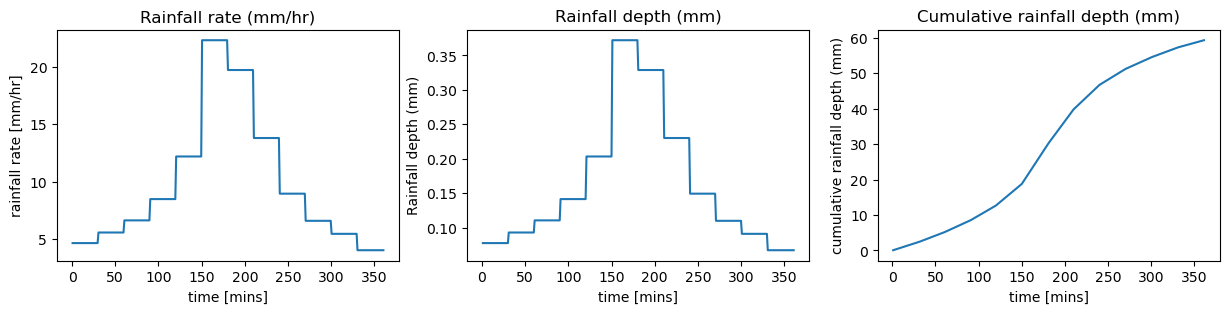

In [19]:
plot_rainfall_depth_each_min(one_cluster, total_duration_minutes)

##### Produce similar outputs for each of the 15 clusters for a 6hr duration event

In [20]:
# Create datetimes to go with values
start = datetime(2022,8,1,0,0,0)
end = start + relativedelta(hours=int(duration[0]))
end = end - timedelta(minutes=1) 
# Allow for the total number of minute sbeing 360 or 361
# (eventually it should just be 361, but this was for testing) 
if total_duration_minutes == (int(duration[0]) * 60) +1:
    seconds = (end - start).total_seconds() + 61
else:    
    seconds = (end - start).total_seconds() + 60 
# Create list of datetimes     
step = timedelta(minutes=1)
datetimes = []
for i in range(0, int(seconds), int(step.total_seconds())):
    datetimes.append(start + timedelta(seconds=i))           

In [21]:
# Produce data with formatted data column (save with and without date column formatted)
clusters_rainfall_data_ls = []    
for cluster_number in range(1,16):
    # Get the data for just this cluster, for the relevant duration
    one_cluster = get_one_cluster_one_variable(profiles, cluster_number,'[2:10 - 6:45) hr' )
    # Find the rainfall depth associated with each minute
    one_cluster = find_rainfall_depth_each_min(one_cluster, total_event_rainfall)
    # Save to file (without column headers)
    one_cluster.to_csv("6hr_100yrRP/PreLossRemoval/cluster{}.csv".format(cluster_number), index = False, header = False)
    
#     # Add the cumulative totals
#     one_cluster = add_cumulative_values(one_cluster)
#     #  Add to list
#     clusters_rainfall_data_ls.append(one_cluster)
    
#     # Add a formatted date column
#     one_cluster = one_cluster[['minute', 'rainfall_depth_this_min']].copy()
#     one_cluster.to_csv("6hr_100yrRP/PreLossRemoval/cluster{}.csv".format(cluster_number),  index = False, header=False) 
    
#     # Convert back to dates for ReFH2
#     one_cluster['minute'] = datetimes
#     # Save to file (without column headers)
#     one_cluster.to_csv("6hr_100yrRP/PreLossRemoval/cluster{}_formatteddates.csv".format(cluster_number), index = False, header = False) 

# Plot depth per minute: 15 clusters + idealised single-peak profile
## Pre loss removal

In [23]:
sp_profile = pd.read_csv("../ReFH2_singlepeak/6hr_100yrRP_6.01h_1mintimestep.csv")

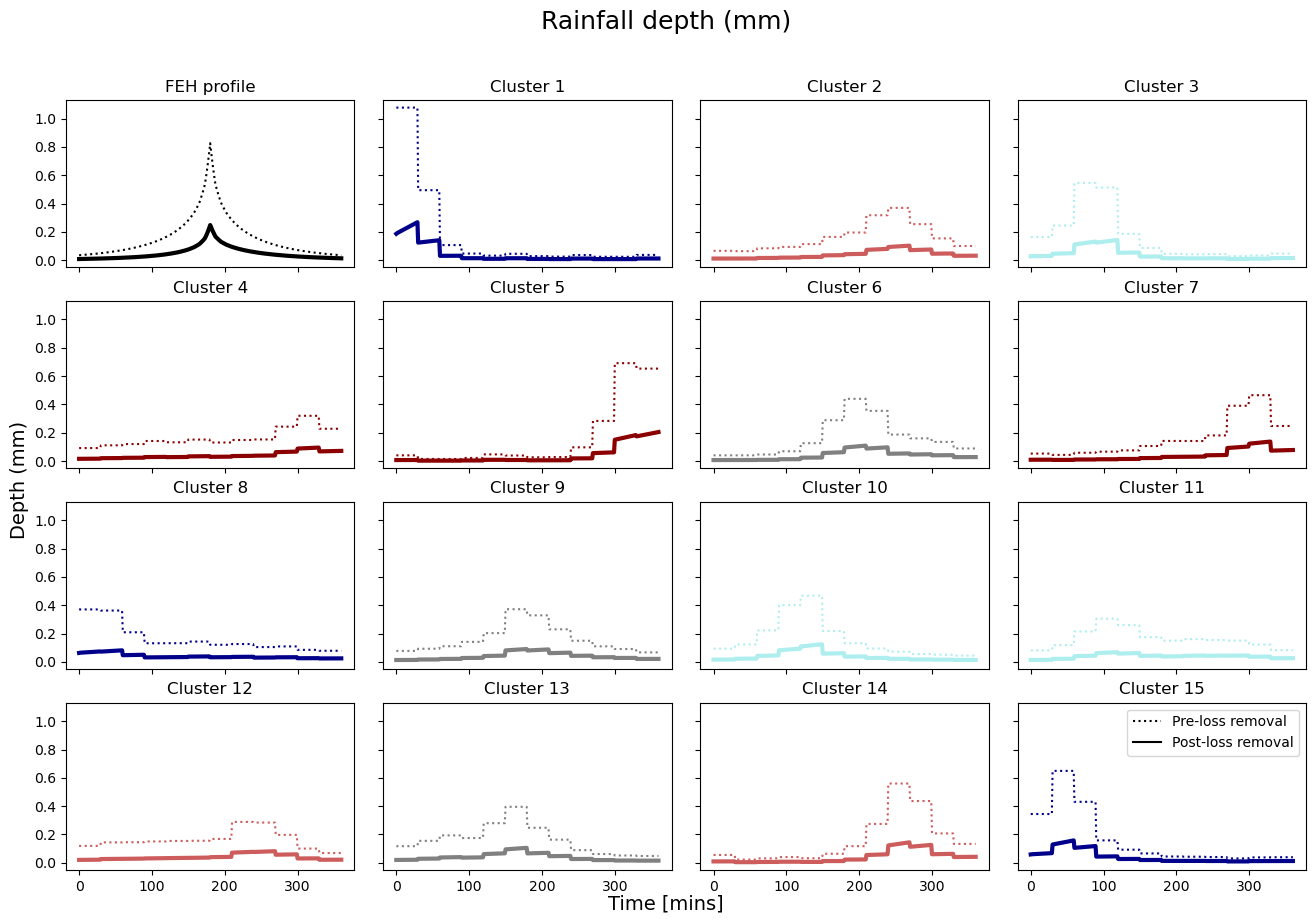

In [51]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize =(16,10), sharey=True, sharex = True)
plt.subplots_adjust(wspace=0.1)
fig.suptitle("Rainfall depth (mm)", fontsize=18, y=0.97)

# loop through tickers and axes
ax = axs.ravel()[0]
ax.plot(range(0,361), sp_profile['100 year design rainfall - FEH 2013 model'][:361], color = 'black', linewidth=1.5, linestyle = 'dotted') 
ax.plot(range(0,361), sp_profile['Total net rain mm (100 year) - urbanised model'][:361], linewidth = 3, color='black') 
ax.set_title("FEH profile")

for num, cluster_number in enumerate(range(1,16)):
    # Get the axis to plot on
    ax = axs.ravel()[num+1]
    # Read in the data and plot
    pre_loss_removal = pd.read_csv('6hr_100yrRP/PreLossRemoval/cluster{}.csv'.format(cluster_number), names =['Time', 'Rain'])
    ax.plot(range(0,361), pre_loss_removal['Rain'] ,color = colors[num], linewidth=1.5, linestyle = 'dotted')   
    
    # Read in the data and plot
    post_loss_removal = pd.read_csv('6hr_100yrRP/PostLossRemoval/cluster{}_urban_summer.csv'.format(cluster_number))
    ax.plot(range(0,361), post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'], 
            color = colors[num],linewidth=3)   
    # Set tiles
    ax.set_title("Cluster {}".format(cluster_number))
fig.text(0.5, 0.07, 'Time [mins]', ha='center', fontsize =14)
fig.text(0.09, 0.5, "Depth (mm)", va='center', rotation='vertical', fontsize =14);

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='black', linestyle='dotted'),
                Line2D([0], [0], color='black')]

plt.legend(custom_lines, ['Pre-loss removal', 'Post-loss removal']);

## Post loss removal

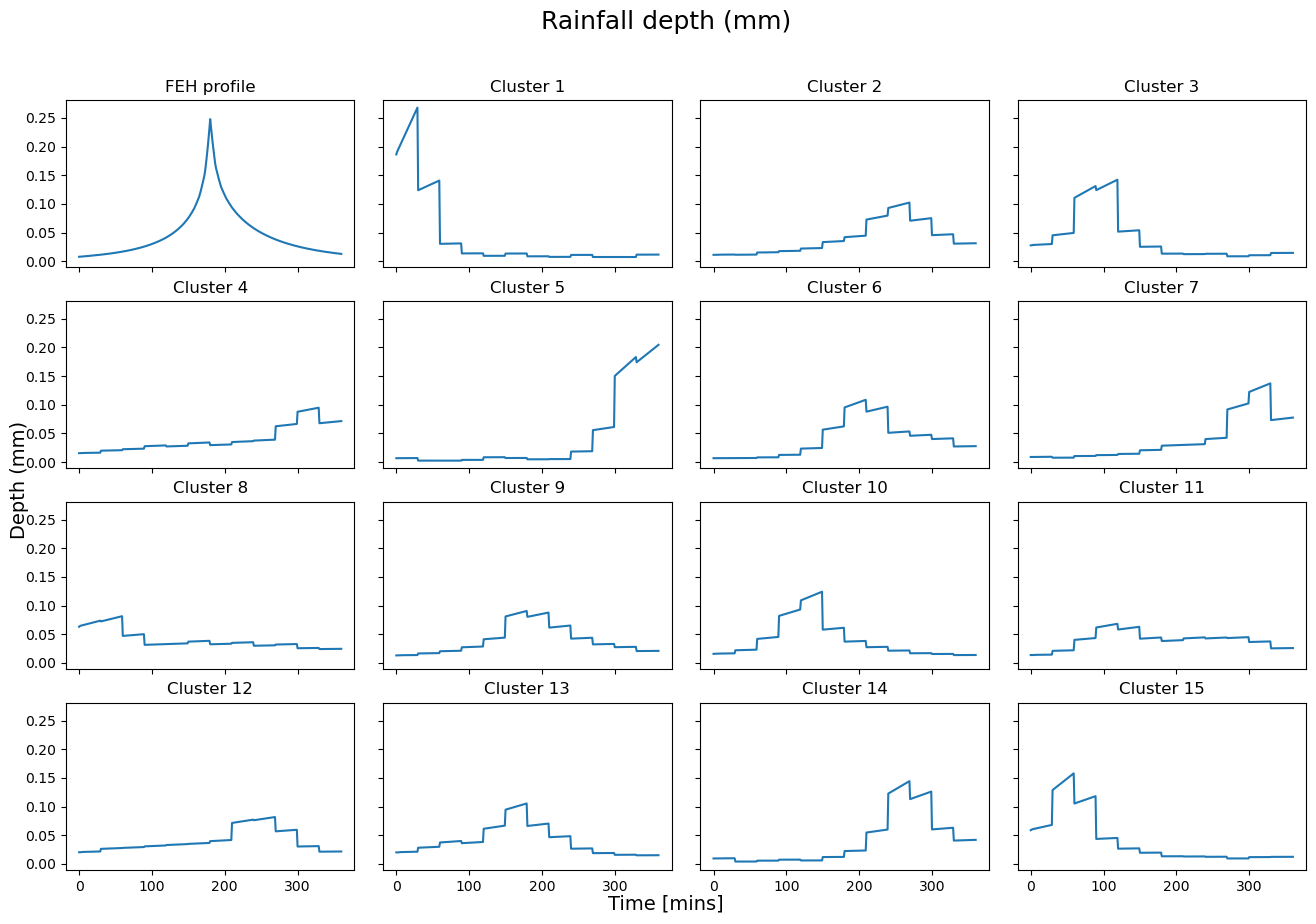

In [11]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize =(16,10), sharey=True, sharex = True)
plt.subplots_adjust(wspace=0.1)
fig.suptitle("Rainfall depth (mm)", fontsize=18, y=0.97)

# loop through tickers and axes
ax = axs.ravel()[0]
ax.plot(range(0,361), sp_profile['Total net rain mm (100 year) - urbanised model'][:361]) 
ax.set_title("FEH profile")

for num, cluster_number in enumerate(range(1,16)):
    # Get the axis to plot on
    ax = axs.ravel()[num+1]
    # Read in the data and plot
    post_loss_removal = pd.read_csv('6hr_100yrRP/PostLossRemoval/cluster{}_urban_summer.csv'.format(cluster_number))
    ax.plot(range(0,361), post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'], 
            color = colors[num])   
    # Set tiles
    ax.set_title("Cluster {}".format(cluster_number))
fig.text(0.5, 0.07, 'Time [mins]', ha='center', fontsize =14)
fig.text(0.09, 0.5, "Depth (mm)", va='center', rotation='vertical', fontsize =14);

# Plot the cumulative rainfall depth for all profiles + FEH profile

Max rainfall (after loss removal):  0.26802
Max rainfall (before loss removal):  1.07777
Total event rainfall (after loss removal):  14.43977
Total event rainfall (before loss removal):  59.29
Max rainfall (after loss removal):  0.10232
Max rainfall (before loss removal):  0.36912
Total event rainfall (after loss removal):  14.43978
Total event rainfall (before loss removal):  59.29
Max rainfall (after loss removal):  0.14223
Max rainfall (before loss removal):  0.54555
Total event rainfall (after loss removal):  14.43978
Total event rainfall (before loss removal):  59.29
Max rainfall (after loss removal):  0.09487
Max rainfall (before loss removal):  0.31951
Total event rainfall (after loss removal):  14.43978
Total event rainfall (before loss removal):  59.29
Max rainfall (after loss removal):  0.20458
Max rainfall (before loss removal):  0.69135
Total event rainfall (after loss removal):  14.43978
Total event rainfall (before loss removal):  59.29
Max rainfall (after loss removal): 

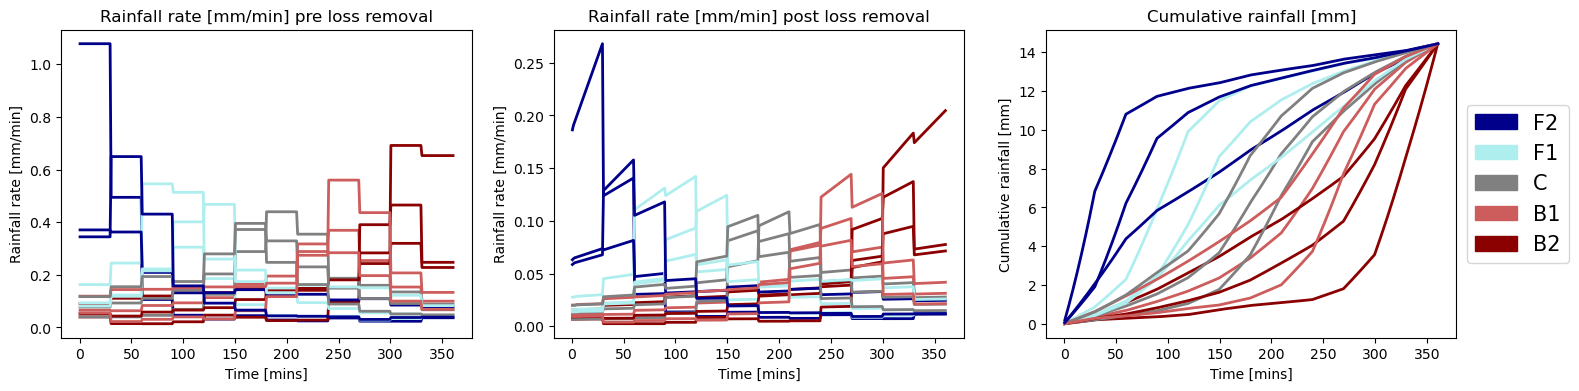

In [14]:
fig, axes = plt.subplots(1, 3,figsize=(18,4), sharex =True, sharey = False)

for cluster_number in range(1,16):
    
    # Read in pre and post loss removal data
    pre_loss_removal = pd.read_csv('../ObservedProfiles/' + "6hr_100yrRP/PreLossRemoval/cluster{}.csv".format(cluster_number), names = ['Time', 'Rainfall'])
    post_loss_removal = pd.read_csv('../ObservedProfiles/' + "6hr_100yrRP/PostLossRemoval/cluster{}_urban_summer.csv".format(cluster_number))
    
    # Find cumulative rainfall rate
    post_loss_removal['cumulative_rainfall_this_min'] = post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].cumsum()
    
    # Plot pre loss removal rainfall rate
    axes[0].plot(np.array(range(total_duration_minutes))+0.5,pre_loss_removal['Rainfall'], color=colors[cluster_number-1], linewidth = 2)   
    axes[0].set_ylabel('Rainfall rate [mm/min]')
    axes[0].set_title('Rainfall rate [mm/min] pre loss removal')
    axes[0].set_xlabel('Time [mins]')
    
    # Plot post loss removal rainfall rate
    axes[1].plot(np.array(range(total_duration_minutes))+0.5,post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'], 
                 color=colors[cluster_number-1], linewidth = 2)   
    axes[1].set_xlabel('Time [mins]')
    axes[1].set_ylabel('Rainfall rate [mm/min]')
    axes[1].set_title('Rainfall rate [mm/min] post loss removal')
    
    # Plot cumulative rainfall rate
    axes[2].plot(np.array(range(total_duration_minutes))+0.5,post_loss_removal['cumulative_rainfall_this_min'], 
                 color=colors[cluster_number-1], linewidth = 2)   
    axes[2].set_xlabel('Time [mins]')
    axes[2].set_ylabel('Cumulative rainfall [mm]')
    axes[2].set_title('Cumulative rainfall [mm]')
        
    # CHECK WHETHER TOTAL RAINFALL VOLUME IS CONSERVED
    print("Max rainfall (after loss removal): ", round(post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].max(),5))
    print("Max rainfall (before loss removal): ", round(pre_loss_removal['Rainfall'].max(),5))
    
    print("Total event rainfall (after loss removal): ", round(post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].sum(),5))
    print("Total event rainfall (before loss removal): ", round(pre_loss_removal['Rainfall'].sum(),5))
    
colors_leg = ['darkblue', 'paleturquoise', 'grey', 'indianred', 'darkred']
texts = ['F2','F1','C', 'B1', 'B2'] 
patches = [ mpatches.Patch(color=colors_leg[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.15, 0.5), loc='center', ncol=1, prop={'size': 15} );    